# TBD

Step of the codes :
- Import modules 
- Define settings 
- Define functions 
- Download pc p1, pc pred, pc optim and pc obs
- Get candidates emulations
- Download EOF solver
- Download candidates data 
- Project candidates on EOF basis and get pseudo-pcs 
- Plot figure

# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Settings

### Variables

In [2]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
var_ceres = ['rsdt','rsut', 'rlut']
truncations = [18, 18, 8, 28, 22]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/home/globc/peatier/PPE/CNRMppe_save/PPE/ENSEMBLE2/files/npy/'

# Functions

In [4]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [5]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [6]:
def get_3D_psl_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    psl = df['psl']
    
    return psl

In [7]:
def get_3D_LW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    LW = df['rlut']
    
    return LW

In [8]:
def get_3D_SW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    SW = df['rsut']# - df['rsdt']
    
    return SW

In [9]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [10]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [11]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix 
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [12]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

# Get data 

In [15]:
path_file = path_files+'npy/'
Mean = {}
for var in variables :
    filename = 'CNRMppe_decomposition_mean_'+str(var)+'.npy'
    Mean_tmp =  pd.read_pickle(path_file+filename).to_xarray().to_array()
    Mean[var] = Mean_tmp[0,:,:].rename({'variable':'mode'})

In [16]:
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(var)+'.npy')
W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(var)+'.npy')

# Download PCs

In [40]:
path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'

pc_PPE = {}
pc_obs = {}
pc_pred = {}
pc_p1 = {}
pc_optim = {}

for var in variables :
    ## PPE
    path = path_files+'nc/'
    filename = 'pc_PPE_'+var+'.nc'
    pc_PPE_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    dims_dict = {'time' : 'members', 'mode' : 'modes'}
    pc_PPE[var] = pc_PPE_tmp.rename_dims(dims_dict)
    
    ## observations
    path = path_files+'nc/'
    filename = 'pc_obs_'+var+'.nc'
    pc_obs[var] = xr.open_mfdataset(path+filename,combine='by_coords')
    
    ## p1 - the first line of pc_PPE
    pc_p1[var] = pc_PPE[var]['pcs'][0,:]
    
    ## predictions
    path = path_files+'nc/'
    filename = 'pc_pred_'+var+'.nc'
    pc_pred_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    pc_pred[var] = pc_pred_tmp.rename({'__xarray_dataarray_variable__' : 'pcs'})
    
    ## optim 
    path = path_files+'nc/'
    filename = 'optim_pc_PPE_'+var+'_multi.nc'
    pc_optim[var] = xr.open_mfdataset(path+filename,combine='by_coords')

In [41]:
## emulated candidates 
path = path_files+'nc/'
filename = 'PC_candidates_multi.nc'
pc_cand_emul_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
pc_cand_emul = pc_cand_emul_tmp.rename({'__xarray_dataarray_variable__' : 'pcs'})

index_list = []
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    cpt_trunc += 1
    for i in range(0,trunc) :
        tmp = 'EOF '+str(i+1)+' '+var
        index_list.append(tmp)
        
df_cand_emul = pd.DataFrame(pc_cand_emul['pcs'].values, columns = index_list)
#df_cand_emul

In [45]:
df_optim = pd.DataFrame()
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    for i in range(1,trunc+1,1) :
        df_optim['EOF '+str(i)+' '+var] = pc_optim[var]['EOF '+str(i)].values
    cpt_trunc += 1
df_optim

,EOF 1 tas,EOF 2 tas,EOF 3 tas,EOF 4 tas,EOF 5 tas,EOF 6 tas,EOF 7 tas,EOF 8 tas,EOF 9 tas,EOF 10 tas,...,EOF 13 LW,EOF 14 LW,EOF 15 LW,EOF 16 LW,EOF 17 LW,EOF 18 LW,EOF 19 LW,EOF 20 LW,EOF 21 LW,EOF 22 LW
0,0.053160,0.591416,0.177104,0.866376,-0.718467,-0.659540,-0.043037,0.556143,0.368302,-1.033655,...,-0.159089,-0.098080,-0.975946,-0.281429,-0.185335,0.176638,-0.306223,0.099916,0.654717,-1.133540
1,-1.011793,1.339372,1.565485,-0.114614,-2.109373,0.004198,0.100010,-0.431711,0.024609,0.297679,...,1.248335,-0.379823,1.387612,-0.496919,1.171483,-0.344917,-1.007774,-0.146686,1.032652,0.005230
2,-0.384961,0.556234,-0.396392,-0.059524,-1.318948,0.235323,0.289680,-0.226521,-0.024458,-0.126000,...,-0.022752,0.251287,0.507676,-0.793967,-1.047735,-0.120428,0.425087,-0.646289,0.349680,0.252881
3,-0.270988,0.208586,0.606975,1.005541,-0.550034,0.227348,-0.026970,-0.256704,0.440614,-0.158742,...,-0.600543,-0.630755,-0.060103,0.575651,-0.300881,0.266193,1.178987,0.072353,0.537443,-0.899818
4,-0.299352,0.309064,2.783405,-0.125267,-0.715340,0.787181,0.565415,-1.050571,0.028596,0.408537,...,0.113916,0.216559,1.040399,-0.862432,0.791998,-0.452841,0.318223,-0.636524,-0.220940,0.151882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,0.466418,0.773169,-0.844275,-0.764109,-0.894000,-0.046908,-0.715592,-0.161486,0.356400,0.834269,...,0.581893,0.022396,1.208086,0.564893,-0.204087,-0.464265,-1.084542,-0.313619,0.227772,1.008630
4985,-0.627136,0.590900,1.234955,-0.434820,0.205836,0.752006,-0.547507,1.033733,-0.695691,0.887514,...,-1.116369,-0.482902,-0.237134,-0.166283,0.349432,0.410475,-0.424606,-0.472399,-0.800697,0.719077
4986,0.203675,0.899939,0.128886,0.561057,0.135676,-0.040235,0.744816,1.110649,-0.499779,-0.410537,...,0.760812,0.622922,0.191361,-1.198509,1.687077,-0.203311,-1.362365,-0.125646,-0.036607,0.229306
4987,-0.938848,0.741590,1.616601,-0.705452,0.071571,0.880203,-0.589251,1.118385,-0.486073,1.071030,...,0.480644,0.564887,-0.021714,-1.196097,0.777178,0.084771,-0.312025,-0.859730,-0.545371,0.771119


# Download EOF solver

In [46]:
import pickle
path = path_files+'pkl/'

solver = {}
for var in variables :
    # open a file, where you stored the pickled data
    file = open(path+'solver_'+var+'.pkl', 'rb')

    # dump information to that file
    solver[var] = pickle.load(file)

    # close the file
    file.close()

In [47]:
eofs = {}
variances = {}
for var in variables :
    eofs[var] = solver[var].eofsAsCovariance(pcscaling=1)
    variances[var] = solver[var].varianceFraction() 

In [49]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = 'tas_*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, ['tas'])

In [50]:
lat = p1_amip['lat']
lon = p1_amip['lon']
eofs_nb = arange(1,104,1)
#eofs_xr = {}
eofs_combined = {}

for var in variables :
    eofs_xr = xr.DataArray(eofs[var], 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
    ## --Combine the modes for reconstruction
    eofs_combined[var] = eofs_xr

# Get reference p1_amip

In [82]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'

p1_amip = dict()
diff_p1 = dict()
X_p1_w = dict()

for var in ['tas', 'psl'] :
    print(var)
    p1_amip[var] = load_monthly_clim(path, filename, var).groupby(['lat','lon']).mean().to_xarray()
    
### --- CERES data

df_ceres = load_monthly_clim(path, filename, var_ceres)

var = 'SW'
df_ceres[var] = df_ceres['rsut']# + df_ceres['rsut'] 
p1_amip[var] = df_ceres[var].groupby(['lat','lon']).mean().to_xarray()
print(var)

var = 'LW'
df_ceres[var] =  df_ceres['rlut']
p1_amip[var] = df_ceres[var].groupby(['lat','lon']).mean().to_xarray()
print(var)
 
### --- Precipitation pr 

var = 'pr'
print(var)
p1_amip[var] = load_monthly_clim(path, filename, var).groupby(['lat','lon']).mean().to_xarray()


tas
psl
SW
LW
pr


In [ ]:
X_rec_p1 = {}
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    rec_anom_mod_w = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc_p1[var][0:trunc], nb_dims=2)
    MSE_rec_p1[var] = MSE_rec(rec_anom_mod_w, rec_anom_obs_w[var], Mean[var], W_rmse_2D)
    cpt_trunc +=1

# Get observation

### BEST observations - tas

In [94]:
path_observation = '/data/scratch/globc/peatier/obs/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
var = 'tas'

In [95]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['tas'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [96]:
obs = {}
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

## GPCP observations - pr

In [97]:
path_observation = '/data/scratch/globc/peatier/obs/GPCP/regrid_CNRM/'
filename_obs = 'pr_mon_mean_197901-198112_regrid.nc'
var = 'pr'

In [98]:
## --- Initial method
path = path_observation
df_obs = load_monthly_clim(path, filename_obs, var)
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

## CERES observations - fluxes

In [99]:
path_observation = '/data/scratch/globc/peatier/obs/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

In [100]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
#df_obs

In [101]:
df_obs['SW'] =   df_obs['toa_sw_all_mon']# + df_obs['toa_lw_all_mon'] 
# df_obs['toa_sw_all_mon']
obs['SW'] = df_obs['SW'].groupby(['lat','lon']).mean().to_xarray()
obs['SW'] = obs['SW']#['SW']

df_obs['LW'] =  df_obs['toa_lw_all_mon']
obs['LW'] = df_obs['LW'].groupby(['lat','lon']).mean().to_xarray()
obs['LW'] = obs['LW']#['LW']

## NCEP observations - psl

In [103]:
path_observation =  '/data/scratch/globc/peatier/obs/NCEP/regrid_CNRM/'
filename_obs = 'psl_1m_1979-1981_NCEP_regrid.nc'

In [104]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename_obs,combine='by_coords')
#file
var = ['psl']
df_obs = load_monthly_clim(path_observation, filename_obs, var)

In [105]:
obs['psl'] = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs['psl'] = obs['psl']['psl']

## Weighted anomaly

In [64]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
X_obs = dict()
X_obs_w = dict()
for var in variables :

    ## --Observations
    X_obs[var] = obs[var] - Mean[var]
    X_obs_w[var] = X_obs[var]*W_eof_2D

# Analysis Candidates

In [65]:
nb_p_select = ['p930', 'p931', 'p933', 'p934', 
               'p935', 'p936', 'p937', 'p938', 'p939']

In [ ]:
p1_amip['tas'] = p1_amip['tas']['tas'] ## to be changed to dataarray !
p1_amip['psl'] = p1_amip['psl']['psl']
p1_amip['pr'] = p1_amip['pr']['pr']

In [129]:
## -- CNRM-CM candidates simulations :
filename='*_amip_*.nc'
amip_select={}

for var in variables : 
    amip_select[var] = {}

for p in nb_p_select :
    print(p)
    
    ## -- tas 
    var=['tas']
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_tas_xarr(path, filename, var)
    amip_select[var[0]][p] = amip_tmp
    
    ## -- pr 
    var=['pr']
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_pr_xarr(path, filename, var)
    amip_select[var[0]][p] = amip_tmp
    
    ## -- psl
    var=['psl']
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_psl_xarr(path, filename, var)
    amip_select[var[0]][p] = amip_tmp
    
    ## -- SW 
    var=['rsdt', 'rsut']
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_SW_xarr(path, filename, var)
    amip_select['SW'][p] = amip_tmp
    
    ## -- LW 
    var=['rlut']
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_LW_xarr(path, filename, var)
    amip_select['LW'][p] = amip_tmp

p930
p931
p933
p934
p935
p936
p937
p938
p939


In [130]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']

In [131]:
## --Analysis of the candidates  :
e_sel = {}
U_sel = {}
X_sel_rec = {}
p_sel = {}
X_obs_rec = {}
cpt=0

for var in variables :
    print(var)

    e_sel_list = []
    U_sel_list = []
    X_sel_rec_list = []
    p_sel_list = []
    
    trunc = truncations[cpt]
    
    for p in nb_p_select :
        
        X_sel = amip_select[var][p]
        #print(X_sel)
        
        ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
        X_sel['lat'] = eofs_combined[var]['lat']
        X_sel['lon'] = eofs_combined[var]['lon']
          
        ## -- Full error MSE : 
        e_sel_tmp = MSE(X_sel, obs[var], W_rmse_2D)
        e_sel_list.append(e_sel_tmp)
    
        ## -- Project the candidates :
        X_sel_w = (X_sel - Mean[var])*W_eof_2D
        U_sel_tmp = solver[var].projectField(X_sel_w, weighted=False, 
                                             eofscaling=1)
        U_sel_list.append(U_sel_tmp)
    
        ## --Reconstruct the candidates :
        X_sel_rec_tmp = reconstruct_X(eofs_combined[var][0:trunc], pc=U_sel_tmp[0:trunc], 
                                      nb_dims=2)
        X_sel_rec_list.append(X_sel_rec_tmp)
        
        ## -- Reconstruct obs :
        pc=pc_obs[var]['pseudo_pcs'][0:trunc]
        X_obs_rec[var] = reconstruct_X(eofs_combined[var][0:trunc], pc, nb_dims=2)
    
        ## -- Parametric errors RMSE_rec : 
        p_sel_tmp = MSE_rec(X_sel_rec_tmp, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_sel_list.append(float(p_sel_tmp))
        
        ## -- Non-parametric error :
    
    e_sel[var] = e_sel_list
    U_sel[var] = U_sel_list
    X_sel_rec[var] = X_sel_rec_list
    p_sel[var] = p_sel_list
    cpt+=1

tas
pr
psl
SW
LW


In [132]:
## -- Faire DataFrame :
df_sel = {}
cpt_trunc = 0
for var in variables :
    df_sel[var] = pd.DataFrame()
    trunc = truncations[cpt_trunc]
    cpt_trunc+=1
    for i in range(0,trunc,1) :
        U_sel_df = []
        for mb in range(0,len(nb_p_select),1) :
            U_sel_df.append(float(U_sel_list[mb][i]))
    
        df_sel[var]['EOF '+str(i+1)] = U_sel_df
    
    df_sel[var]['p'] = p_sel[var]

In [133]:
def diff_3D_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = mod - obs
    
    return diff

In [134]:
## --Analysis of the candidates  :
e_diff = {}
u_diff = {}
p_diff = {}
e_sel = {}
u_sel = {}
cpt=0

for var in variables :
    print(var)

    e_diff_list = []
    u_diff_list = []
    p_diff_list = []
    e_sel_list = []
    u_sel_list = []
    
    trunc = truncations[cpt]
    
    for p in nb_p_select :
        
        X_sel = amip_select[var][p]
        #print(X_sel)
        
        ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
        X_sel['lat'] = eofs_combined[var]['lat']
        X_sel['lon'] = eofs_combined[var]['lon']
          
        ## -- 3D full error [obs - mod]
        e_diff_tmp = (X_sel - obs[var])
        e_diff_list.append(e_diff_tmp)
    
         ## -- Project the candidates :
        X_sel_w = (X_sel - Mean[var])*W_eof_2D
            
        U_sel = solver[var].projectField(X_sel_w, weighted=False, eofscaling=1)
    
        ## --Reconstruct the candidates :
        X_sel_rec = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc=U_sel[0:trunc], nb_dims=2)
    
        ## -- 3D p error [X_obs_rec - X_mod_rec]
        p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_diff_list.append(p_diff_tmp)
    
        ## -- 3D u error [e - p]
        u_diff_tmp = (e_diff_tmp - p_diff_tmp)
        u_diff_list.append(u_diff_tmp)
        
        ## -- Compute integrated metrics 
    
        ## -- Compute RMSE 
        e = MSE(X_sel, obs[var], W_rmse_2D)
        print(float(e))
        e_sel_list.append(float(e))
        
        ## - non-param. error u(\theta_0)
        diff = u_diff_tmp**2 * W_rmse_2D
        u = (diff.sum(['lat', 'lon']))
        u_sel_list.append(float(u))
    
    e_diff[var] = e_diff_list
    #print(e_diff[var])
    u_diff[var] = u_diff_list
    p_diff[var] = p_diff_list
    e_sel[var] = e_sel_list
    u_sel[var] = u_sel_list
    df_sel[var]['e'] = e_sel_list
    df_sel[var]['u'] = u_sel_list
    cpt+=1

tas
1.9426265048533333
1.6864729875661426
1.7342598564409073
1.7261447566707493
1.619440606244133
1.9656516347714468
1.8937695967536112
2.2033473855211247
1.8823963400131858
pr
3.529486641142809
2.889888054115986
2.429555170757482
2.6275316119086
2.9592912716325004
2.053251134369773
3.021216930184583
2.9677091098358988
3.3293089979935506
psl
56218.96006009568
38655.3315736855
40628.95560173455
41519.98196755075
42710.11072073695
48003.09866916923
40733.43371661995
41381.0929767547
48980.71653663027
SW
697.0997047590297
255.42773962436928
192.01552869005073
212.90426603061385
183.7899377352729
261.79458214779044
176.06676466082973
764.1549131936628
152.72884620131123
LW
101.18760427135895
82.35507493994422
64.5201609973002
108.00335148136406
74.93939098034475
69.28067460117813
123.61400607660994
106.79934256429159
154.49606954972575


In [138]:
## -- p1 reference CNRM-CM6-1

e_diff_p1 = {}
e_p1 = {}
p_p1 = {}
u_p1 = {}
U_p1 = {}
p_diff_p1 = {}
u_diff_p1 = {}
X_p1_rec = {}

cpt = 0

for var in variables :
    print(var)
    trunc = truncations[cpt]

    ## -- 3D full error [obs - mod]
    e_diff_p1[var] = (p1_amip[var] - obs[var])

    ## -- Project 
    X_sel = p1_amip[var]
    U_p1[var] = pc_p1[var].values

    ## --Reconstruct 
    X_p1_rec[var] = reconstruct_X(eofs_combined[var][0:trunc], pc=U_p1[var][0:trunc], 
                                  nb_dims=2)

    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff_p1[var] = diff_3D_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)

    ## -- 3D u error [e - p]
    u_diff_p1[var] = (e_diff_p1[var] - p_diff_p1[var])
    
    ## - integrated metric 
    e = MSE(X_sel, obs[var], W_rmse_2D)
    e_p1[var] = float(e)

    ## --Param. error p(\theta_0)
    p = MSE_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)
    p_p1[var] = float(p)
    print(e_p1[var])
    
    ## - non-param. error u(\theta_0)
    diff = u_diff_p1[var]**2 * W_rmse_2D
    u = (diff.sum(['lat', 'lon']))
    u_p1[var] = float(u)
    
    cpt+=1

tas
2.0131773694393877
pr
10.742016044376479
psl
34436.38599508788
SW
184.17243516429775
LW
59.827733796731465


In [161]:
## -- e_tot
e_tot = []
for i in range(0,len(nb_p_select),1) :
    s = 0
    for var in variables :
        s = s + e_sel[var][i]/e_p1[var] 
    e = s/len(variables)
    e_tot.append(round(float(e), 2))

e_tot

[1.68, 1.0, 0.88, 1.05, 0.91, 1.03, 1.09, 1.7, 1.22]

## Figure

### Concatenate everything in a big Data Frame 

In [185]:
Names= []
for i in range(1,trunc+2,1) : 
    tmp = 'EOF '+str(i)
    Names.append(tmp)
#Names.append('p')
#Names

In [186]:
## -- Emulated members
df_pc_pred = pd.DataFrame(pc_pred['pcs'].values.transpose(), columns=Names)
df_fig = df_pc_pred.copy()#.reset_index()
df_fig['Legend'] = ['Emulated members']*len(df_fig)
#df_fig

In [187]:
## -- Members with lower error than reference
df_pc_low = df_optim.drop('LHS index', axis=1)
df_pc_low['Legend'] = ['$p_{tas}(\\theta_i)<p_{tas}(\\theta_0)$']*len(df_pc_low)
df_fig = df_fig.append(df_pc_low)
#df_fig

In [188]:
## -- Observations 
U_obs_list = []
Names = []
cpt=1
cols = []
#cols = ['index']
U_obs_tmp = pc_obs['pseudo_pcs'].values
U_obs = U_obs_tmp[0:trunc]
for i in U_obs :
    U_obs_list.append(float(i))
    tmp = 'EOF '+str(cpt)
    cols.append(tmp)
    Names.append(tmp)
    cpt+=1
df_obs = pd.DataFrame([U_obs_list], columns=Names)
#df_obs['index'] = 0
df_obs['p'] = 0
df_obs['Legend'] = 'BEST observations'
#cols.append('p')
cols.append('Legend')
df_obs_sort = df_obs[cols]
df_fig = df_fig.append(df_obs_sort)
#df_fig

In [189]:
## -- Reference CNRM-CM6-1
U_p1_list = []
U_p1_tmp = pc_p1.values
U_p1 = U_p1_tmp[0:trunc]
for i in U_p1 : 
    U_p1_list.append(float(i))
df_p1 = pd.DataFrame([U_p1_list], columns=Names)
#df_p1['index'] = 0
#df_p1['p'] = p_p1
df_p1['Legend'] = 'CNRM-CM6-1 ref.'
df_p1_sort = df_p1[cols]
df_fig = df_fig.append(df_p1_sort)
#df_fig

In [190]:
## -- Emulated candidates
df_pc_best = pd.DataFrame(pc_cand_emul['pcs'].values, columns=Names)

names = []
for i in range(1, len(df_pc_best)+1, 1) :
    tmp = 'Emulated candidate '+str(i)
    names.append(tmp)
df_pc_best['Legend'] = names 
df_fig = df_fig.append(df_pc_best)
#df_fig

In [191]:
## -- CNRM-CM candidates 
names=[]
for i in range(1,len(nb_p_select)+1,1) :
    tmp = 'CNRM-CM candidates '+str(i)
    names.append(tmp)
df_sel['Legend'] = names 
df_fig = df_fig.append(df_sel)
df_fig

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,EOF 19,Legend
0,0.053160,0.591416,0.177104,0.866376,-0.718467,-0.659540,-0.043037,0.556143,0.368302,-1.033655,0.433413,1.109543,0.321662,1.513375,0.452024,-0.274896,-0.594091,-0.293426,0.866866,Emulated members
1,-0.259237,0.647073,-0.452515,1.409053,-0.870643,-0.667772,-1.261793,-0.218841,-0.226251,-0.316316,-0.687209,-0.269193,0.721732,1.066529,-0.923238,1.317172,0.553034,0.158447,-0.789680,Emulated members
2,-0.050450,0.146491,-1.425103,-0.870566,0.249998,0.354165,-0.285270,-1.353141,0.577560,-0.725585,0.106226,1.624095,0.920702,1.138461,1.913375,-1.009280,0.666002,0.200703,0.690488,Emulated members
3,1.133615,-1.250214,-1.322137,1.910634,-1.905300,-0.142851,-0.127473,0.419342,0.802691,0.352713,-0.373750,-0.253786,-0.894195,-0.389659,-0.691260,0.796070,0.045510,-0.170147,-1.014062,Emulated members
4,-0.657846,-0.100945,2.477285,-0.208477,0.485037,0.204115,-0.430936,-0.878425,0.267369,-0.884294,0.385899,1.002614,0.633994,1.667335,0.034571,-0.438587,-0.113232,0.295160,1.076145,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,-0.139728,-0.615073,-0.402047,-0.565324,-1.745219,-0.089587,-1.123301,-0.224219,-1.022702,-1.625667,-0.822199,0.404917,1.271143,-1.262192,-1.079406,-0.385516,-0.941991,0.631819,NaN,CNRM-CM candidates 6
6,-0.854939,-0.830540,-0.144140,-0.652677,-0.422323,-0.131075,-0.969898,-0.516061,-0.270941,-0.655341,0.333433,-0.932708,0.823534,-1.684205,-0.056017,-0.166544,0.214263,-1.116737,NaN,CNRM-CM candidates 7
7,-1.083471,-0.705506,0.320147,1.323144,1.665279,0.707099,1.141031,-0.393163,0.053576,-0.484099,0.416585,0.298121,-0.434534,-0.152266,0.150779,-1.379126,0.924089,0.568878,NaN,CNRM-CM candidates 8
8,-0.781885,-1.093168,1.005290,0.056933,-0.010199,0.518677,0.345156,-0.293421,-0.434037,-1.276043,0.189791,0.375397,-0.619463,-0.805357,0.622699,-1.306066,-0.717183,-0.267255,NaN,CNRM-CM candidates 9


<Figure size 1080x1080 with 0 Axes>

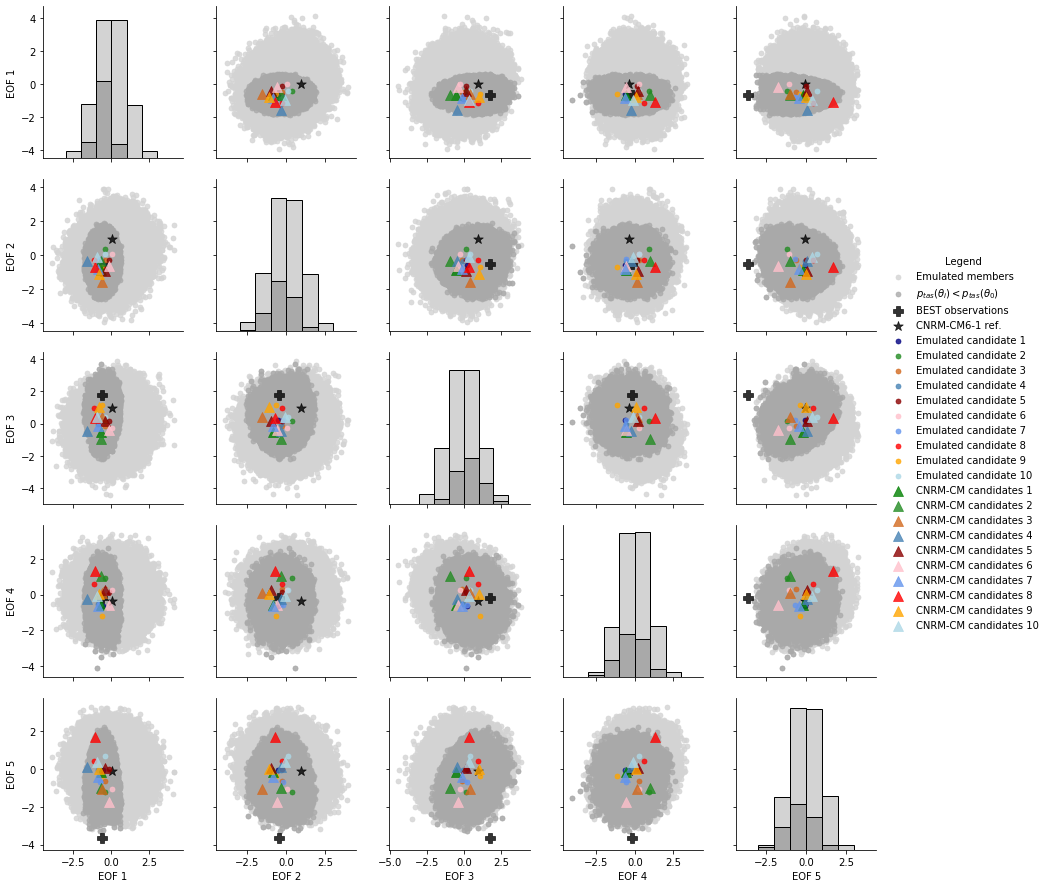

In [192]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray',  'darkgray','black', 'black', 'navy', 
     'forestgreen', 'chocolate', 'steelblue', 'darkred', 'pink',
    'cornflowerblue', 'red', 'orange', 'lightblue', 'green',
     'forestgreen', 'chocolate', 'steelblue', 'darkred', 'pink',
    'cornflowerblue', 'red', 'orange', 'lightblue', 'green']
m = ['.','.', 'P','*', 
     '.','.','.','.','.','.','.','.','.','.',
     '^', '^', '^', '^', '^', '^', '^', '^', '^', '^']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Candidates_tas_EOF_rev.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()